In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as mtri
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from skfem import *
from skfem import MeshTri, Basis, ElementTriP2, ElementVector
from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import ddot
from skfem.visuals.matplotlib import plot

Let us start with the two meshes

In [2]:
# import numpy as np


# # Define new vertices based on the given dimensions
r_side = .06  # mm (width)
z_mid = .05  # mm (junction height)
z_top = .15  # mm (top of the square)
z_between = .1
# Define the vertices for the adjusted shape
vertices = np.array([
    [0.0, 0.0],   # Bottom-left (triangle)
    [r_side, z_mid],   # Bottom-right (shared vertex at junction)
    [r_side, z_between],
    [r_side, z_top],   # Top-right (rectangle)
    [0.0, z_top], # Top-left (rectangle)
    [0.0, z_between],
    [0.0, z_mid], # Middle shared vertex (junction)
])

# Define the connectivity of the mesh
triangles = np.array([
    [0, 6, 1],  # Triangle below
    [6, 2, 1],  # First rectangle triangle
    [6, 5, 2],  # Second rectangle triangle
    [5, 3, 2],
    [5, 4, 3],
])

# Create the mesh
mesh = MeshTri(vertices.T, triangles.T)

# Refining the mesh while keeping equal spacing in x and y
mesh = mesh.refined(5)  # Increase this if needed for finer resolution

# Define boundary markers
boundary_markers = {
    "left": lambda x: np.abs(x[0] - 0.0) < 1e-8,        # Left edge (x = 0)
    "right": lambda x: np.abs(x[0] - r_side) < 1e-8,         # Right edge (x = r)
    "top": lambda x: np.abs(x[1] - z_top) < 1e-8,       # Top edge (y = z_top)
    "diagonal": lambda x: np.abs(x[1] - x[0] * z_mid / r_side) < 1e-8,  # Adjust diagonal equation
}

mesh = mesh.with_boundaries(boundary_markers)

# Define the finite element basis
temperature_e_P1 = ElementTriP2()
temperature_e_P2 = ElementTriP2()
stress_e = ElementVector(ElementTriP2())  # Ensures displacement field is vector-valued

temperature_basis = Basis(mesh, temperature_e_P1)
fbasis_gamma = temperature_basis.boundary({'top'})  # Boundary basis for Neumann condition for Heat Equation

temperature_basis_P2_temporarily = temperature_basis.with_element(ElementTriP2())
temperature_basis_P2 = Basis(mesh, temperature_e_P2)
stress_basis = Basis(mesh, stress_e)

In [3]:
temperature_basis.get_dofs({'right', 'diagonal'})

<skfem DofsView(MeshTri1, ElementTriP2) object>
  Number of nodal DOFs: 97 ['u']
  Number of facet DOFs: 96 ['u']

Now the physics parameters

In [4]:
# Physical parameters
rho = 5320
c = 367.8

rhoc = rho * c
print(rhoc)
#Converting them to mm
# rhoc = 1.95624e6 #* (1e-9)# Density * Specific heat J/m^3K to J/mm^3K
# print(rhoc)
# K = 10 ** 4.32 # Thermal conductivity
# K = 7.2  # Thermal conductivity
sigma_SB = 5.6703e-8 #* (10e-6)  # Stefan-Boltzmann constant (W/m^2.K^4) to  (W/mm^2.K^4)
epsilon_1 = .50  # Emissivity of the crystal
epsilon_2 = 1  # Emissivity of the quartz glass
T_S = 1238 + 273.15 #Melting point GaAs
T_r = 20 + 273.15
K =  (10 ** 4.32) * ((T_S) ** (-1.09)) #* (10e-3)  # Thermal conductivity  (W/Km) to W/Kmm
print(K)
alpha = 1.06e-5  # Thermal expansion coefficient
T0 = 0 #T_r  # Reference temperature

# Tensor
C11 = 1.12e11
C12 = 0.34e11
C13 = 0.46e11
C22 = 1.12e11
C23 = 0.46e11
C33 = 1e11
C44 = 0.51e11

C = np.array([
    [C11, C12, C13,  0  ],
    [C12, C22, C23,  0  ],
    [C13, C23, C33,  0  ],
    [ 0,   0,   0,  C44 ]
])

1956696.0
7.154095656093703


Heat Equation Weak Form

In [5]:
@BilinearForm
def mass(u, v, w):
    r = w.x[0]  # Radial coordinate
    return rhoc * u * v * r

@BilinearForm
def stiffness_r(u, v, w):
    r = w.x[0]
    return K * u.grad[0] * v.grad[0] * r

@BilinearForm
def stiffness_z(u, v, w):
    r = w.x[0]
    return K * u.grad[1] * v.grad[1] * r

# Define the radiative heat flux as a LinearForm
@LinearForm
def neumann(v, w):
    r, z = w.x[0], w.x[1]  # Radial and axial coordinates

    T_boundary = w['T_boundary']
    T_top_right = w['T_top_right']   # Top right temp
    T_top_right_grad = w['T_top_right_grad']

    T_ambient4sigma = ((T_top_right ) * (sigma_SB ** (1/4)))**4 + K * T_top_right_grad / epsilon_1

    q_R = - epsilon_1 * epsilon_2 * ((T_boundary * (sigma_SB ** (1/4)))**4 - T_ambient4sigma)

    return q_R * v * r

Help Functions for the Stress Equation

In [6]:
def axisymmetric_strain(u, r):
    """Compute the axisymmetric symmetric gradient (strain)"""
    grad_u = u.grad  # Already correct shape (2,2,3072,3)

    du_dr = u.grad[0, 0]  # ∂u_r / ∂r  → Shape (3072,3)
    du_dz = u.grad[1, 0]  # ∂u_r / ∂z  → Shape (3072,3)
    dv_dr = u.grad[0, 1]  # ∂u_z / ∂r  → Shape (3072,3)
    dv_dz = u.grad[1, 1]  # ∂u_z / ∂z  → Shape (3072,3)

    u_r = u[0]  # Shape (3072,6)

    # Explicitly stack into the correct shape (3,3,3072,3)
    eps_u = np.stack([
        [du_dr, np.zeros_like(du_dr), 0.5 * (du_dz + dv_dr)],
        [np.zeros_like(du_dr), u_r / r, np.zeros_like(du_dr)],
        [0.5 * (du_dz + dv_dr), np.zeros_like(du_dr), dv_dz]
    ], axis=0)  # Stack along axis=0 to preserve full shape
    
    return eps_u

def fct_C(x):
    """Double Dot Product with the Fourth Order Tensor
    Input 3 by 3 matrix, elements, nodes, output 3 by 3 matrix, elements, nodes.
    """

    #Flatten the nonzero elements
    xflat = np.array([
        x[0, 0], 
        x[1, 1],
        x[2, 2],
        x[0, 2]
    ]) 
    y = np.einsum('ij,jmn->imn', C, xflat)
    
    #Shape it back
    # result = np.array([
    #     [y[0], 0, y[3]],
    #     [0, y[1], 0],
    #     [y[3], 0, y[2]]
    # ])
    result = np.zeros_like(x)
    result[0, 0] = y[0]
    result[1, 1] = y[1]
    result[2, 2] = y[2]
    result[0, 2] = y[3]
    result[2, 0] = y[3]

    return result

def thermal_strain(T):
    I = np.eye(3)  # Shape (3,3)
    # T shape elements (3072), nodes (3)
    return np.einsum('ij,ab->ijab', I, alpha * (T - T0))

Stress Equation Weak Form

In [ ]:
# Define weak form of elasticity
@BilinearForm
def bilinear(u, v, w):
    r = w.x[0]

    # Extract r-coordinate
    eps_u = axisymmetric_strain(u, r)
    eps_v = axisymmetric_strain(v, r)
    # Stress-strain relationship (Hooke's Law for isotropic material)
    sigma_u = fct_C(eps_u)

    doubledotlhs = np.einsum('ijkl,ijkl->kl', sigma_u, eps_v)

    return doubledotlhs * r # Multiply by r for axisymmetry

# Define load vector (body forces)
@LinearForm
def thermal_force(v, w):
    r = w.x[0]
    eps_v = axisymmetric_strain(v, r)
    Temp_Field = w['Temperature_Field']
    therm_strain = thermal_strain(Temp_Field)
    Cthe_str = fct_C(therm_strain)
    doubledotrhs = np.einsum('ijkl,ijkl->kl', Cthe_str, eps_v)
    return doubledotrhs * r


Heat Solver

In [8]:
# Time-stepping parameters
dt = 100
t_end = 1 * 3600.0
n_steps = int(t_end / dt)

# Find the index of the top-right vertex
max_x = np.max(mesh.p[0])  # Maximum x-coordinate
max_y = np.max(mesh.p[1])  # Maximum y-coordinate

# Find the vertex index corresponding to (max_x, max_y)
top_right_index = np.where((mesh.p[0] == max_x) & (mesh.p[1] == max_y))[0][0]

# Parameters
num_segments = 10
# t_end = 7 * 3600  # 7 hours in seconds
z_segments = np.linspace(0, z_top, num_segments + 1)  # 10 equal segments
max_decrease_per_step = 10  # Maximum random decrease per step

In [ ]:
#Heater Configuration

# Initial condition (time t=0)
DT = 100
lin_profile = lambda x: DT * (x[1] - z_top) + T_S
u_init = temperature_basis.project(lin_profile)

import numpy as np
class TimeDependentDirichlet:
    def __init__(self, t):
        self.t = t

    def update_time(self, t):
        self.t = t

    def __call__(self, x):
        z = x[1]
        alp = (t_end - self.t) / t_end 
        # alp = 1
        a = DT * alp
        b = (T_S - z_top * DT - T_r)* alp + T_r
        return a * z + b 
        # return T_r

    
    def gradient_at_top_right(self):
        alp = (t_end - self.t) / t_end
        # alp = 1
        # return 0
        return DT * alp

    def value_at_top_right(self):
        # Temperature at z = z_top
        return self.__call__([0, z_top])

In [10]:
dirichlet = TimeDependentDirichlet(t=0)
# dirichlet.update_time(t=0)
# print(dirichlet.current_b_values)
print("Gradient at top right:", dirichlet.gradient_at_top_right())
print("Value at top right:", dirichlet.value_at_top_right())

Gradient at top right: 100.0
Value at top right: 1511.15


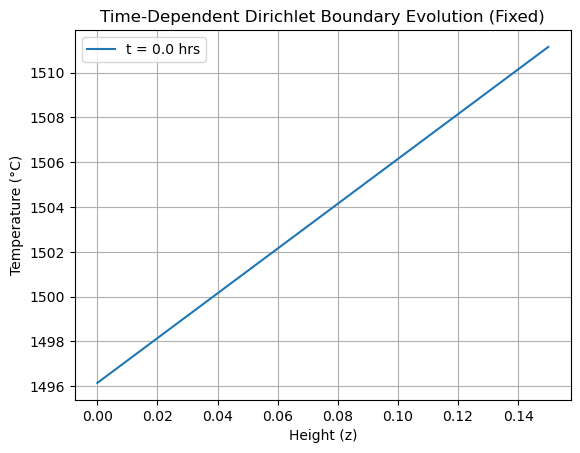

In [11]:
z_plot = np.linspace(0, z_top, 1000)  # Smooth z values
T_plot = np.array([dirichlet([0, z]) for z in z_plot])
plt.plot(z_plot, T_plot, label=f't = {0 / 3600:.1f} hrs')

# Plot segment boundaries
# plt.scatter(z_segments[:-1], dirichlet.compute_initial_b_values()[:-1], color='r', marker='o', label='Initial Segments')

plt.xlabel("Height (z)")
plt.ylabel("Temperature (°C)")
plt.title("Time-Dependent Dirichlet Boundary Evolution (Fixed)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Assemble matrices, these are unchanged over time
K_r = asm(stiffness_r, temperature_basis)
K_z = asm(stiffness_z, temperature_basis)
A = K_r + K_z
M = asm(mass, temperature_basis)

Defined function to solve one step

In [ ]:
def solve_step(t_step, u_prev, dt, BCs):
    """The solver for one step, t_step is the current time of the step
    u_prev, is previous solution, BCs is the boundary condition class
    
    returns new_time, u_next"""
  
    # Apply Dirichlet boundary conditions
    u_bc = temperature_basis.project(BCs)

    # Interpolate the previous solution onto the Neumann boundary
    T_boundary = fbasis_gamma.interpolate(u_prev)
    T_top_right = BCs.value_at_top_right()
    grad_u_z_top_right = BCs.gradient_at_top_right()

    # Prepare the parameters for the Neumann condition
    neumann_params = {'T_boundary': T_boundary, 'T_top_right': T_top_right, 'T_top_right_grad': grad_u_z_top_right}  # Example ambient temperature

    # Assemble the Neumann boundary term
    f = asm(neumann, fbasis_gamma, **neumann_params)

    # Right-hand side
    rhs = M @ u_prev + dt * f

    # Left-hand side
    lhs = M + dt * A

    # Solve the linear system, inducing the dirichlet boundary conditions
    u_next = solve(
        *condense(lhs, rhs, x=u_bc, D=temperature_basis.get_dofs({'right', 'diagonal'}))
    )
    new_t_step = t_step + dt

    BCs.update_time(t_step)  # Update boundary condition
    
    return new_t_step, u_next, u_bc


Complete Solver, makes the temperature evolution

In [14]:
def Heat_Evolution(t_final, n_steps, dt, BCs, u_init):
    """Returns the full solution over time
    Needed:
    t_final: the ending time
    n_steps: number of steps
    dt: step_size
    BCs: the heater_configuration class
    u_init: initial temperature field
    
    returns list of tuples (t, u) for each timestep"""

    #initialization
    u_prev = u_init

    # Apply Dirichlet boundary conditions
    u_init_bc = temperature_basis.project(BCs)

    t_prev = 0.0
    evolution = []
    
    evolution.append((t_prev, u_init, u_init_bc))

    #Check
    print(n_steps == int(t_final / dt))

    for step in range(n_steps):
        
        t_new, u_next, u_bc = solve_step(t_prev, u_prev, dt, BCs)
        evolution.append((t_new, u_next, u_bc))

        t_prev = t_new
        u_prev = u_next
         
    return evolution

In [15]:
# Get unique x and y coordinates
x_coords = np.unique(mesh.p[0, :])
y_coords = np.unique(mesh.p[1, :])

# Create mappings for x and y coordinates to indices
x_to_idx = {x: i for i, x in enumerate(x_coords)}
y_to_idx = {y: i for i, y in enumerate(y_coords)}

def Heat_Stress_Tensor_Saver(n_steps, heatlist, stresslist, x_to_idx, y_to_idx, x_coords, y_coords):

    # Dirichlet nodes
    dirichlet_nodes = temperature_basis.get_dofs({'right', 'diagonal'}).flatten()
    # Get the indices of DOFs that correspond to the nodes
    node_dofs = np.array(temperature_basis.nodal_dofs).flatten() 
    # Create the 4D tensor
    T_tensor = np.zeros((len(y_coords), len(x_coords), 3, n_steps))    

    for step in range(n_steps):
        u_heat = heatlist[step][1]
        u_boundary_val = heatlist[step][2]
        u_sigma = stresslist[step][2]

        u_boundary = np.zeros_like(u_boundary_val)
        u_boundary[dirichlet_nodes] = u_boundary_val[dirichlet_nodes]

        # Extract values of u at the nodes
        u_heat_at_nodes = u_heat[node_dofs]
        u_bcs_at_nodes = u_boundary[node_dofs]
        u_sigma_at_nodes = u_sigma[node_dofs]
        
        # Initialize matrices for this timestep
        boundary_matrix = np.zeros((len(y_coords), len(x_coords)))
        heat_matrix = np.zeros((len(y_coords), len(x_coords)))
        stress_matrix = np.zeros((len(y_coords), len(x_coords)))
        
        # Populate the matrices
        for i, value in enumerate(u_heat_at_nodes):
            x, y = temperature_basis.mesh.p[:, i]
            heat_matrix[y_to_idx[y], x_to_idx[x]] = value
        
        for i, value in enumerate(u_bcs_at_nodes):
            x, y = temperature_basis.mesh.p[:, i]
            boundary_matrix[y_to_idx[y], x_to_idx[x]] = value
        
        for i, value in enumerate(u_sigma_at_nodes):
            x, y = temperature_basis.mesh.p[:, i]
            stress_matrix[y_to_idx[y], x_to_idx[x]] = value
        
        # Store in the tensor
        T_tensor[:, :, 0, step] = boundary_matrix
        T_tensor[:, :, 1, step] = heat_matrix
        T_tensor[:, :, 2, step] = stress_matrix

    return T_tensor


Stress Solver, given the Temperature Field

In [16]:
# Assemble system, unchanged
A_stress = asm(bilinear, stress_basis)

In [17]:
def StressSolver(u_temp):
    """Returns the stress field corresponding to the given temperature field"""
    TemperatureField =temperature_basis.interpolate(u_temp)
    # TemperatureField = temperature_basis_P2.interpolate(temperature_basis_P2_temporarily.project(temperature_basis.interpolate(u_temp)))
    temperature = {'Temperature_Field': TemperatureField}
    
    b = asm(thermal_force, stress_basis, **temperature)

    u = solve(A_stress, b)
    return u

Von Mises Stress Field Maker

In [ ]:
def SigmaField(u_temp, u_stress):

    # Interpolate the solutions on the basis
    u_stress_interpolated = stress_basis.interpolate(u_stress)
    u_temp_interpolated = temperature_basis.interpolate(u_temp)

    # Compute strain tensor at each point in the domain
    r_coords = temperature_basis_P2.interpolate(temperature_basis.doflocs[0])
    eps_u = axisymmetric_strain(u_stress_interpolated, r_coords)

    therm_strain = thermal_strain(u_temp_interpolated)

    Ceps_u = fct_C(eps_u)
    inp = eps_u - therm_strain
    Cthstr = fct_C(therm_strain)

    # Compute stress tensor using Hooke's Law
    sigma_u = Ceps_u - Cthstr  # Apply constitutive relation

    sigma_xx = sigma_u[0, 0]  # σ_11 (σ_rr in cylindrical coordinates)
    sigma_yy = sigma_u[1, 1]  # σ_22 (σ_θθ in cylindrical coordinates)
    sigma_zz = sigma_u[2, 2]  # σ_zz (axial stress)
    sigma_xy = sigma_u[0, 1]  # σ_rθ
    sigma_yz = sigma_u[1, 2]  # σ_θz
    sigma_zx = sigma_u[2, 0]  # σ_zr

    von_mises_stress = np.sqrt(
        0.5 * (
            (sigma_xx - sigma_yy) ** 2 +
            (sigma_yy - sigma_zz) ** 2 +
            (sigma_zz - sigma_xx) ** 2 +
            6 * (sigma_xy ** 2 + sigma_yz ** 2 + sigma_zx ** 2)
        )
    )

    return von_mises_stress

In [19]:
def Complete_Stress_Solver(list_u_temp):
    """"Calculates the max von mises stress at each t"""
    vmstresslist = []
    for t, u_temp, _ in list_u_temp:
        
        u_stress = StressSolver(u_temp)
        u_sigma = SigmaField(u_temp, u_stress)
        u_sigma_flat = temperature_basis.project(u_sigma)
        vmstresslist.append((t, u_sigma, u_sigma_flat, u_sigma.max()))

    return vmstresslist

In [ ]:
import time
# Start time
start_time = time.time()

results = Heat_Evolution(t_final=t_end, n_steps = n_steps, dt = dt, BCs = dirichlet, u_init=u_init)
maxstresslist = Complete_Stress_Solver(results)
# End time
end_time = time.time()

# Calculate and print runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.6f} seconds, for {t_end} time, {n_steps} timesteps")

#To create tensor

# Start time
start_time = time.time()

result_T = Heat_Stress_Tensor_Saver(n_steps=n_steps, heatlist=results, stresslist=maxstresslist, x_to_idx=x_to_idx, 
                         y_to_idx=y_to_idx, x_coords=x_coords, y_coords=y_coords)
# End time
end_time = time.time()

# saving
output_dir="output"
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True) 

np.save(f"{output_dir}/test_save.npy", result_T)

print(f"Runtim for saving: {runtime:.6f} seconds, for {t_end} time, {n_steps} timesteps")
print(f"{result_T.shape} shape of result Tensor")

True
Runtime: 30.697403 seconds, for 3600.0 time, 36 timesteps
Runtim for saving: 30.697403 seconds, for 3600.0 time, 36 timesteps
(97, 33, 3, 36) shape of result Tensor


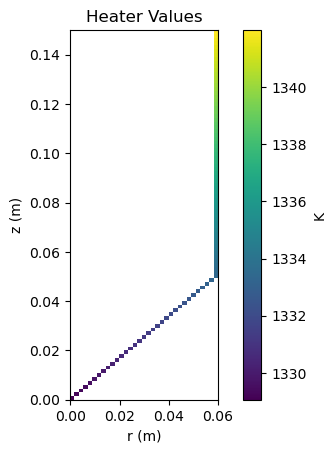

In [21]:
import numpy as np
import matplotlib.pyplot as plt

time_index = 7

masked_data = np.ma.masked_where(result_T[:, :, 0, time_index] <= 0, result_T[:, :, 0, time_index])

plt.imshow(
    masked_data,
    cmap='viridis',
    origin='lower',
    extent=[0, 0.06, 0, 0.15]  # Set physical axis range
)
plt.xlim(0, 0.06)
plt.ylim(0, 0.15)
plt.xlabel("r (m)")
plt.ylabel("z (m)")
plt.colorbar(label="K")  # Add a color scale
plt.title("Heater Values")
plt.show()


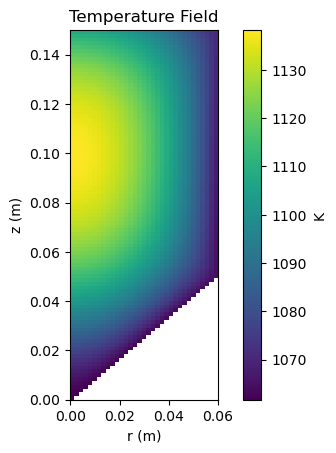

In [26]:
masked_data = np.ma.masked_where(result_T[:, :, 1, 15] <= 0, result_T[:, :, 1, 15])

plt.imshow(
    masked_data,
    cmap='viridis',
    origin='lower',
    extent=[0, 0.06, 0, 0.15]  # Set physical axis range
)
plt.xlim(0, 0.06)
plt.ylim(0, 0.15)
plt.xlabel("r (m)")
plt.ylabel("z (m)")
plt.colorbar(label="K")  # Add a color scale
plt.title("Temperature Field")
plt.show()

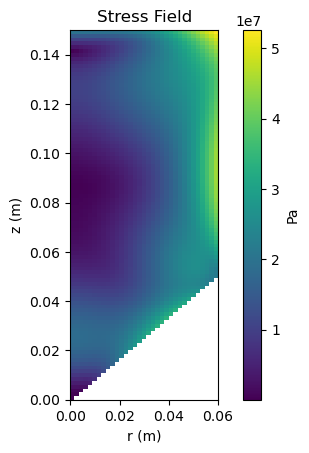

In [27]:
masked_data = np.ma.masked_where(result_T[:, :, 2, -1] <= 0, result_T[:, :, 2, -1])

plt.imshow(
    masked_data,
    cmap='viridis',
    origin='lower',
    extent=[0, 0.06, 0, 0.15]  # Set physical axis range
)
plt.xlim(0, 0.06)
plt.ylim(0, 0.15)
plt.xlabel("r (m)")
plt.ylabel("z (m)")
plt.colorbar(label="Pa")  # Add a color scale
plt.title("Stress Field")
plt.show()